In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

In [27]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        )
        self.classification_head = nn.Sequential(
            nn.Linear(64, 20, bias=True),
            nn.ReLU(),
            nn.Linear(20, 10, bias=True)
        )            
        
    def forward(self, x):
        features = self.net(x)
        return self.classification_head(features.view(features.shape[0], -1))

In [28]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [29]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

In [30]:
def show_confusion_matrix():
    model.eval()
    
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(DEVICE)
            output = model(data)
            
            output = output.data.max(1, keepdim=True)[1].cpu().numpy().reshape(-1)
            y_pred.extend(output)
            
            target = target.cpu().numpy().reshape(-1)
            y_true.extend(target)

    classes = [str(i) for i in range(10)]
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.show()

In [31]:
EPOCHS = 10
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1000
LR = 0.01
LOG_INTERVAL = 100
RANDOM_SEED = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RANDOM_SEED)

In [32]:
train_dataset = MNIST('data/', train=True, download=True, transform=ToTensor())
test_dataset = MNIST('data/', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [33]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

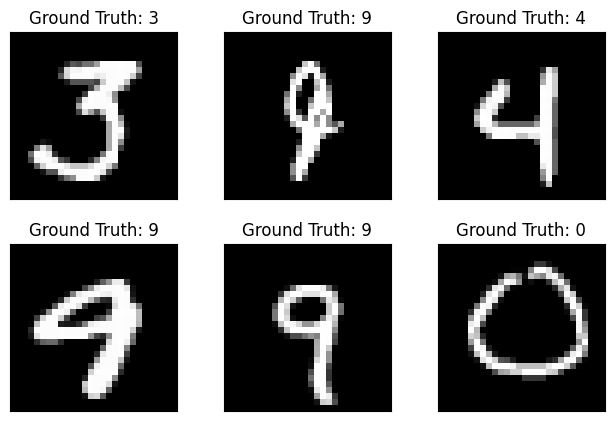

In [34]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

In [35]:
model = CNNClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

In [36]:
print(model)

CNNClassifier(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [44]:
total_params = 0
for param in model.parameters():
    total_params += param.numel()

print('Number of parameters in the model: ', total_params)

Number of parameters in the model:  149798


In [37]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(EPOCHS + 1)]

In [38]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.273497
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.295615
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.293908
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.289799
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.264487
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.241943
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.185691
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.121125
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.869649
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.590155

Test set: Avg. loss: 0.0015, Accuracy: 5193/10000 (52%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.538274
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.075539
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.965033
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.715822
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.566410
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.535900
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.514580
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.363091
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.560177
Trai

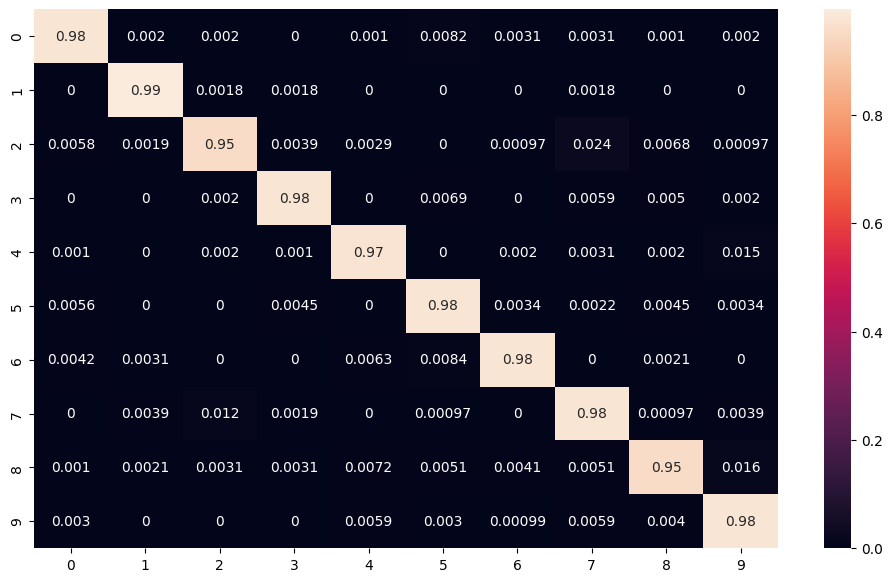

In [39]:
show_confusion_matrix()